# Load Into CNN Stock Predction G-Drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/CNN Stock Prediction"

/content/drive/.shortcut-targets-by-id/11M8JhuGjMeTkxBAoI1sL3lLEa69ylHrV/CNN Stock Prediction


In [ ]:
!ls

'1) Process Stock Data.ipynb'	    Animals		 model.png
'2) Label Stock Data.ipynb'	   'Archived Code'	 models
'3) Calculate Initial Indicators'   Backtester		'Stock CNN Oversampled'
'4) Original Stock CNN.ipynb'	    data		 ta-lib
'5) Feature Selection'		   'Expand Indicators'	 ta-lib-0.4.0-src.tar.gz


# Create Necessary Paths

In [ ]:
import os
from os import path

# create historical data directory
if not path.exists('data/historical/'):
  os.mkdir('data/historical/')

# create directories for data sources
if not path.exists('data/historical/AlphaVantage'):
  os.mkdir('data/historical/AlphaVantage')

if not path.exists('data/historical/YahooFinance'):
  os.mkdir('data/historical/YahooFinance')

# create adjusted data directory
if not path.exists('data/adjusted/'):
  os.mkdir('data/adjusted/')

# create directories for data sources
if not path.exists('data/adjusted/AlphaVantage'):
  os.mkdir('data/adjusted/AlphaVantage')

if not path.exists('data/adjusted/YahooFinance'):
  os.mkdir('data/adjusted/YahooFinance')

# create labeled data directory
if not path.exists('data/labeled/'):
  os.mkdir('data/labeled/')

# create directories for data sources
if not path.exists('data/labeled/AlphaVantage'):
  os.mkdir('data/labeled/AlphaVantage')

if not path.exists('data/labeled/YahooFinance'):
  os.mkdir('data/labeled/YahooFinance')

In [ ]:
!ls 'data'

4_best_model_keras.h5  adjusted  cifar10     IBM_selected_features.csv	labeled_indicators
4_model.png	       animals	 historical  labeled			split


In [ ]:
!ls 'data/historical'
!ls 'data/adjusted'
!ls 'data/labeled'

AlphaVantage  YahooFinance
AlphaVantage  YahooFinance
AlphaVantage  YahooFinance


# Pull Stock Data From AlphaVantage

In [ ]:
from google.colab import userdata
import pandas as pd
import requests
import os

# AlphaVantage API Key
APIKEY = userdata.get('APIKEY')

# target URL
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&apikey={APIKEY}&datatype=csv&outputsize=full'

# pull from API if local file doesn't exist
if not os.path.isfile(f'data/historical/AlphaVantage/{stock}.csv'):
  stock_df = pd.read_csv(url)
  print(f"API call made for {stock} data.")
  data_source = "API"
else:
  stock_df = pd.read_csv(f'data/historical/AlphaVantage/{stock}.csv')
  print(f"Data for {stock} stock read from local csv.")
  data_source = "Local"

# confirm absence of null values
print(stock_df.isnull().sum(axis = 0))

# reverse dataframe order
if data_source == "API":
  stock_df = stock_df.iloc[::-1].reset_index(drop=True)

# store local csv if API call was made
if data_source == "API":
  stock_df.to_csv(f'data/historical/AlphaVantage/{stock}.csv', index=False)

print(stock_df['timestamp'].max())

stock_df.head()


SecretNotFoundError: Secret APIKEY does not exist.

# Pull Data From Yahoo Finance

In [ ]:
import yfinance as yf
import pandas as pd

stock = 'IBM' # change to desired stock

# pull from API if local file doesn't exist
if not os.path.isfile(f'data/historical/YahooFinance/{stock}.csv'):
  yahoo_df = yf.download(stock, period='20y')
  print(f"\nAPI call made for {stock} data.")
  data_source = "API"
else:
  yahoo_df = pd.read_csv(f'data/historical/YahooFinance/{stock}.csv', index_col=False)
  print(f"Data for {stock} stock read from local csv.")
  data_source = "Local"

# confirm absence of null values
print(yahoo_df.isnull().sum(axis = 0))

# yahoo_df.reset_index()

# store local csv and reset index if API call was made
if data_source == "API":
  yahoo_df.to_csv(f'data/historical/YahooFinance/{stock}.csv', index=True)
  yahoo_df = yahoo_df.iloc[::1].reset_index(drop=False)

yahoo_df.head()


Data for IBM stock read from local csv.
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-04-12,89.388145,90.210327,89.292542,89.617592,50.161480,3255780
1,2004-04-13,89.665390,89.904396,88.432121,88.948372,49.786903,5244226
2,2004-04-14,88.049713,89.732315,88.049713,89.579353,50.140083,5560850
3,2004-04-15,89.674950,89.952202,88.967499,89.340347,50.006294,7159033
4,2004-04-16,88.240921,88.288719,87.036331,88.221794,49.380215,11629428


# Compare AlphaVantage and Yahoo Finance Data

In [ ]:
# optional pandas display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 150)

# convert date columns
stock_df['timestamp'] = pd.to_datetime(stock_df['timestamp'], format='%Y-%m-%d')
yahoo_df['Date'] = pd.to_datetime(yahoo_df['Date'], format='%Y-%m-%d')

# truncate Yahoo data to AlphaVantage data
trunc_stock_df = stock_df[stock_df['timestamp'].ge(yahoo_df['Date'].min())]
trunc_stock_df.reset_index(drop=True, inplace=True)

trunc_stock_df.loc[:, trunc_stock_df.columns != 'timestamp'] = trunc_stock_df.loc[:, trunc_stock_df.columns != 'timestamp'].astype('float64').round(2)

yahoo_df.loc[:, yahoo_df.columns != 'Date'] = yahoo_df.loc[:, yahoo_df.columns != 'Date'].astype('float64').round(2)

yahoo_df.head(50)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-04-12,89.39,90.21,89.29,89.62,50.16,3255780
1,2004-04-13,89.67,89.90,88.43,88.95,49.79,5244226
2,2004-04-14,88.05,89.73,88.05,89.58,50.14,5560850
3,2004-04-15,89.67,89.95,88.97,89.34,50.01,7159033
4,2004-04-16,88.24,88.29,87.04,88.22,49.38,11629428
5,2004-04-19,87.86,88.24,87.67,87.90,49.20,4350732
6,2004-04-20,87.95,88.41,86.66,86.66,48.51,4456169
7,2004-04-21,87.14,87.40,86.70,87.25,48.83,4836076
8,2004-04-22,86.52,87.49,85.76,86.75,48.56,8355448
9,2004-04-23,87.00,87.58,86.39,87.27,48.85,5296107


# Normalize Data by Adjusted Close Price

Future Testing:
*   Normalizing by multiplying by ratio expands data range from original data
*   Normalizing by dividing by ratio contains data range within original data



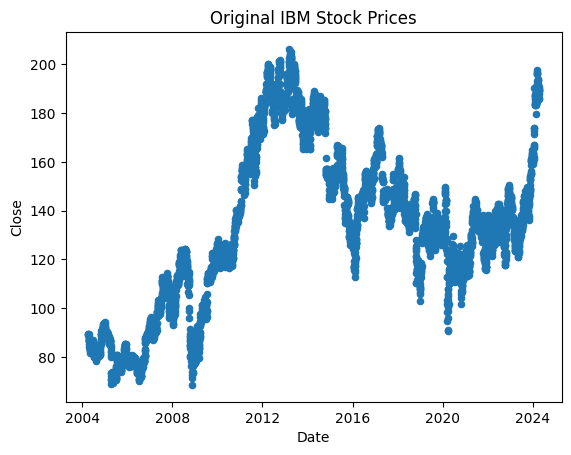

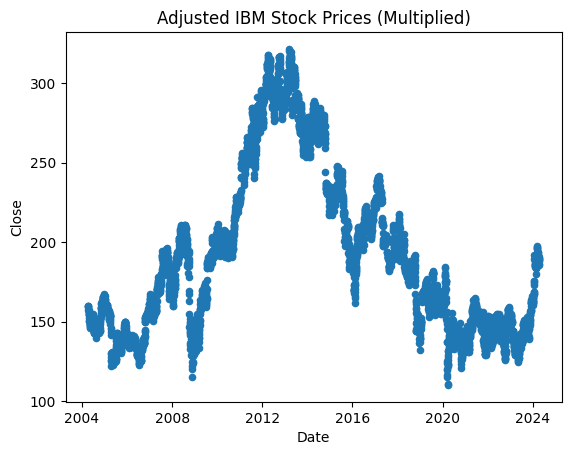

In [ ]:
import matplotlib.pyplot as plt

yahoo_df.plot(kind='scatter', x='Date', y='Close', title=f'Original {stock} Stock Prices')

adjusted_yahoo_df = yahoo_df.copy()

# calculate adjust ratio
adjusted_yahoo_df['adjustRatio'] = adjusted_yahoo_df['Close'] / adjusted_yahoo_df['Adj Close']

multRatio_df = adjusted_yahoo_df.copy()
divRatio_df = adjusted_yahoo_df.copy()

# normalize by adjust ratio (divide)
divRatio_df[['Open', 'High', 'Close', 'Adj Close']] = divRatio_df[['Open', 'High', 'Close', 'Adj Close']].div(divRatio_df.adjustRatio, axis=0)

# round values
divRatio_df.loc[:, divRatio_df.columns != 'Date'] = divRatio_df.loc[:, divRatio_df.columns != 'Date'].astype('float64').round(2)

# divRatio_df.plot(kind='scatter', x='Date', y='Close', title=f'Adjusted {stock} Stock Prices (Divided)')

# normalize by adjust ratio (multiply)
multRatio_df[['Open', 'High', 'Close', 'Adj Close']] = multRatio_df[['Open', 'High', 'Close', 'Adj Close']].multiply(multRatio_df.adjustRatio, axis=0)

# round values
multRatio_df.loc[:, multRatio_df.columns != 'Date'] = multRatio_df.loc[:, multRatio_df.columns != 'Date'].astype('float64').round(2)

multRatio_df.plot(kind='scatter', x='Date', y='Close', title=f'Adjusted {stock} Stock Prices (Multiplied)')

# export dataframes to csv
multRatio_df.to_csv(f'data/adjusted/YahooFinance/{stock}_multipliedRatio.csv', index=False)

In [ ]:
multRatio_df

,Date,Open,High,Low,Close,Adj Close,Volume,adjustRatio
0,2004-04-12,159.71,161.18,89.29,160.12,89.62,3255780,1.79
1,2004-04-13,160.20,160.61,88.43,158.91,88.95,5244226,1.79
2,2004-04-14,157.31,160.31,88.05,160.04,89.58,5560850,1.79
3,2004-04-15,160.19,160.69,88.97,159.60,89.34,7159033,1.79
4,2004-04-16,157.65,157.73,87.04,157.61,88.22,11629428,1.79
...,...,...,...,...,...,...,...,...
5030,2024-04-05,188.59,190.32,188.02,189.14,189.14,2013600,1.00
5031,2024-04-08,189.24,190.24,188.91,189.82,189.82,2678300,1.00
5032,2024-04-09,190.54,191.25,186.66,189.31,189.31,2794200,1.00
5033,2024-04-10,187.42,187.92,185.52,186.04,186.04,3081700,1.00


#Stock Data Visualization